# 1. Introduction

Heart disease is the leading cause of mortality globally, accounting for 31% of all deaths annually. Early detection plays a crucial role in reducing its impact. This project leverages machine learning algorithms to predict heart disease based on patient data, enabling early intervention and improved healthcare outcomes.

**Dataset Overview:**
- **Source:** Heart Failure Prediction Dataset (Kaggle).
- **Size:** 918 rows, 12 columns.
- **Features:** Patient information such as age, cholesterol, max heart rate, and ECG data.
- **Target:** `HeartDisease` (binary: 0 = No, 1 = Yes).

**Objective:**
- Explore and preprocess the dataset.
- Engineer features to improve model performance.
- Implement and evaluate various machine learning models.
- Provide insights and recommendations based on the analysis.

**Significance:**
The study highlights how machine learning models can aid healthcare professionals in making data-driven decisions, potentially saving lives and reducing healthcare costs.


# 2. Data Loading and Exploration

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('heart.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nFirst Few Rows:\n", df.head())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (918, 12)

Columns:
 ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

First Few Rows:
    Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


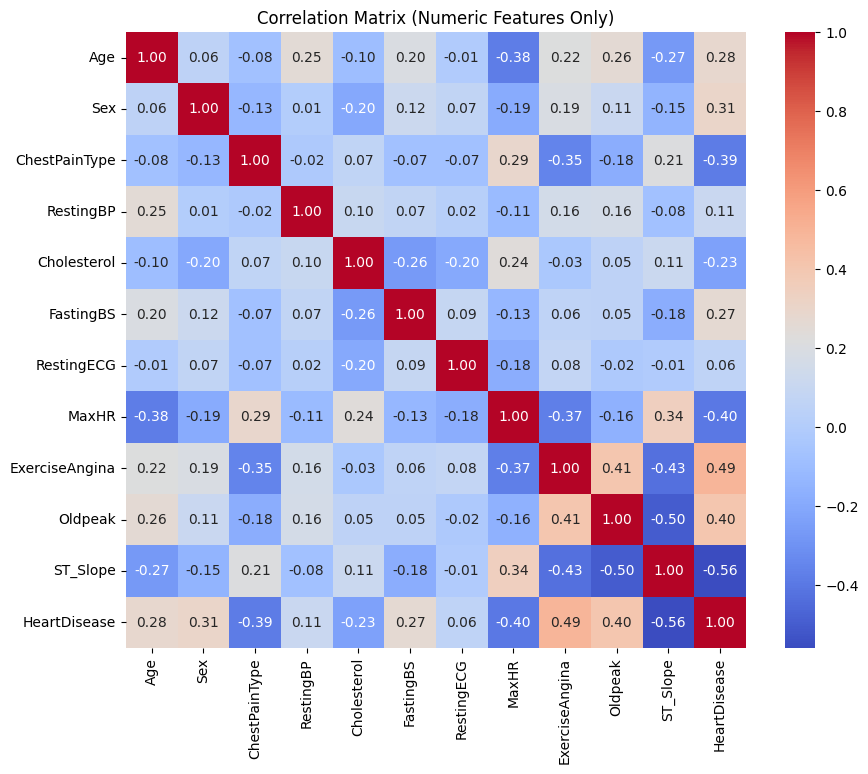

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()

Analysis: From this correlation matrix, we can see the correlation of the features in the dataset with each other, and most importantly their correlation with heart disease. Age and Fasting blood sugar appear to have a small to moderate correlation with heart disease, with cholesterol having a small to moderate inverse correlation. We could say this represents that a higher age and fasting blood pressure could indicate a higher likelihood of heart disease. Resting blood pressure seems to have the smallest correlation with heart disease among these features. The highest correlations are seen with max heart rate and oldpeak. Max heart rate has a high negative correlation with heart disease, meaning a lower maximum heart rate can very likely indicate an increased risk of heart disease. Oldpeak has a high correlation with heart disease, which follows as oldpeak measures the depression between the first and second parts of an ST segment in an ECG, which can indicate reduced blood flow to the heart. 

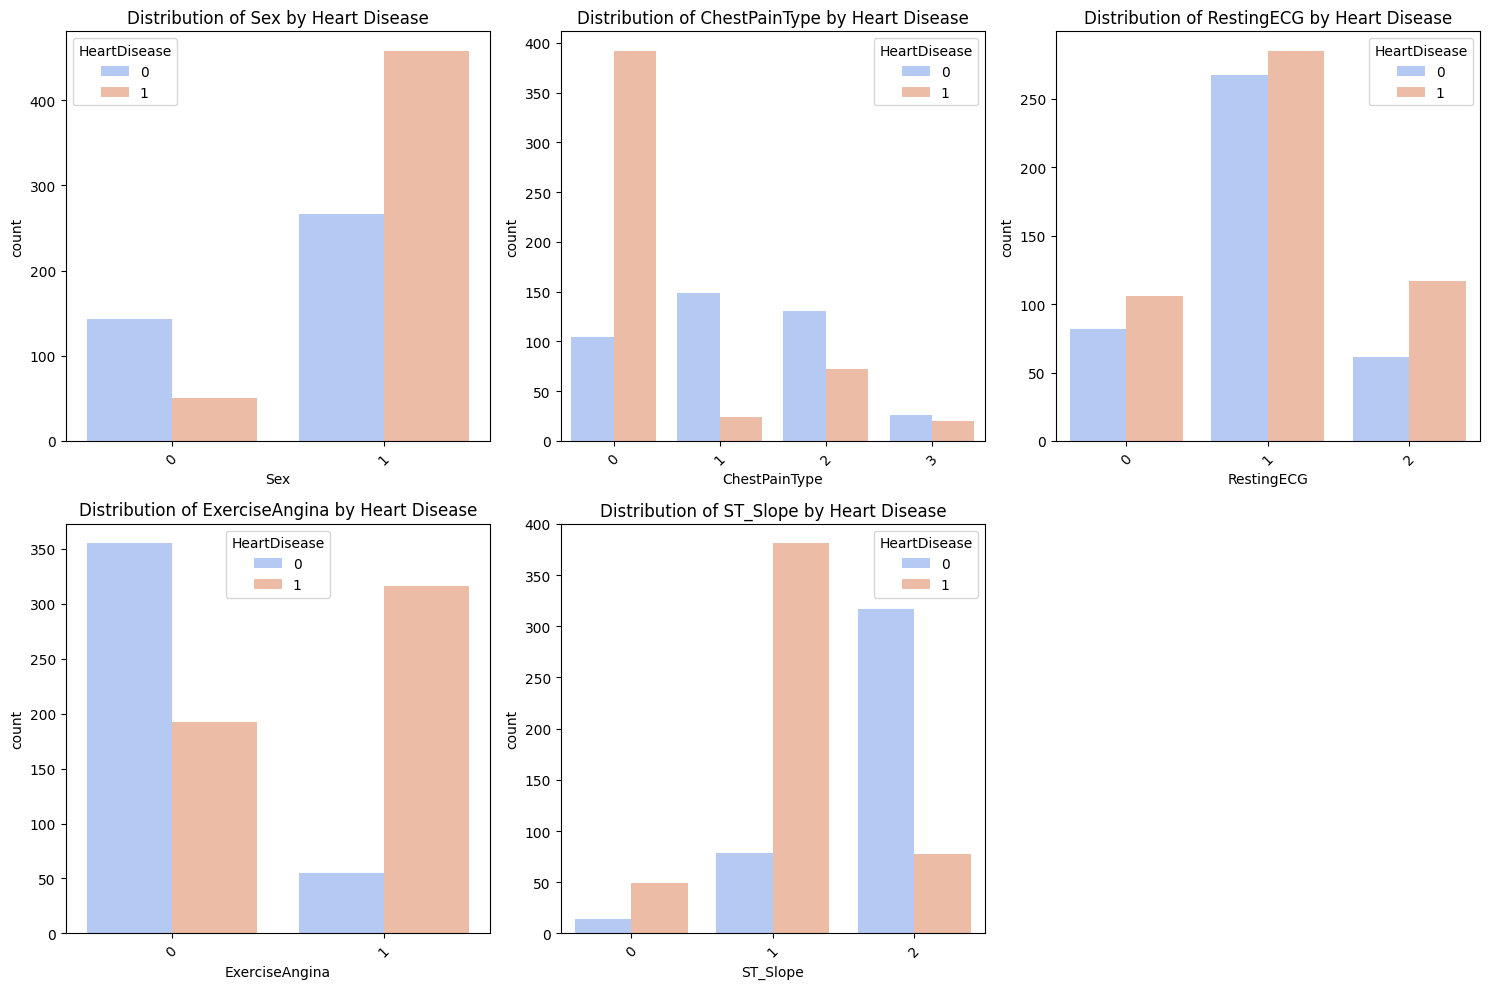

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for categorical features
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=df, x=col, hue='HeartDisease', palette='coolwarm')
    plt.title(f'Distribution of {col} by Heart Disease')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

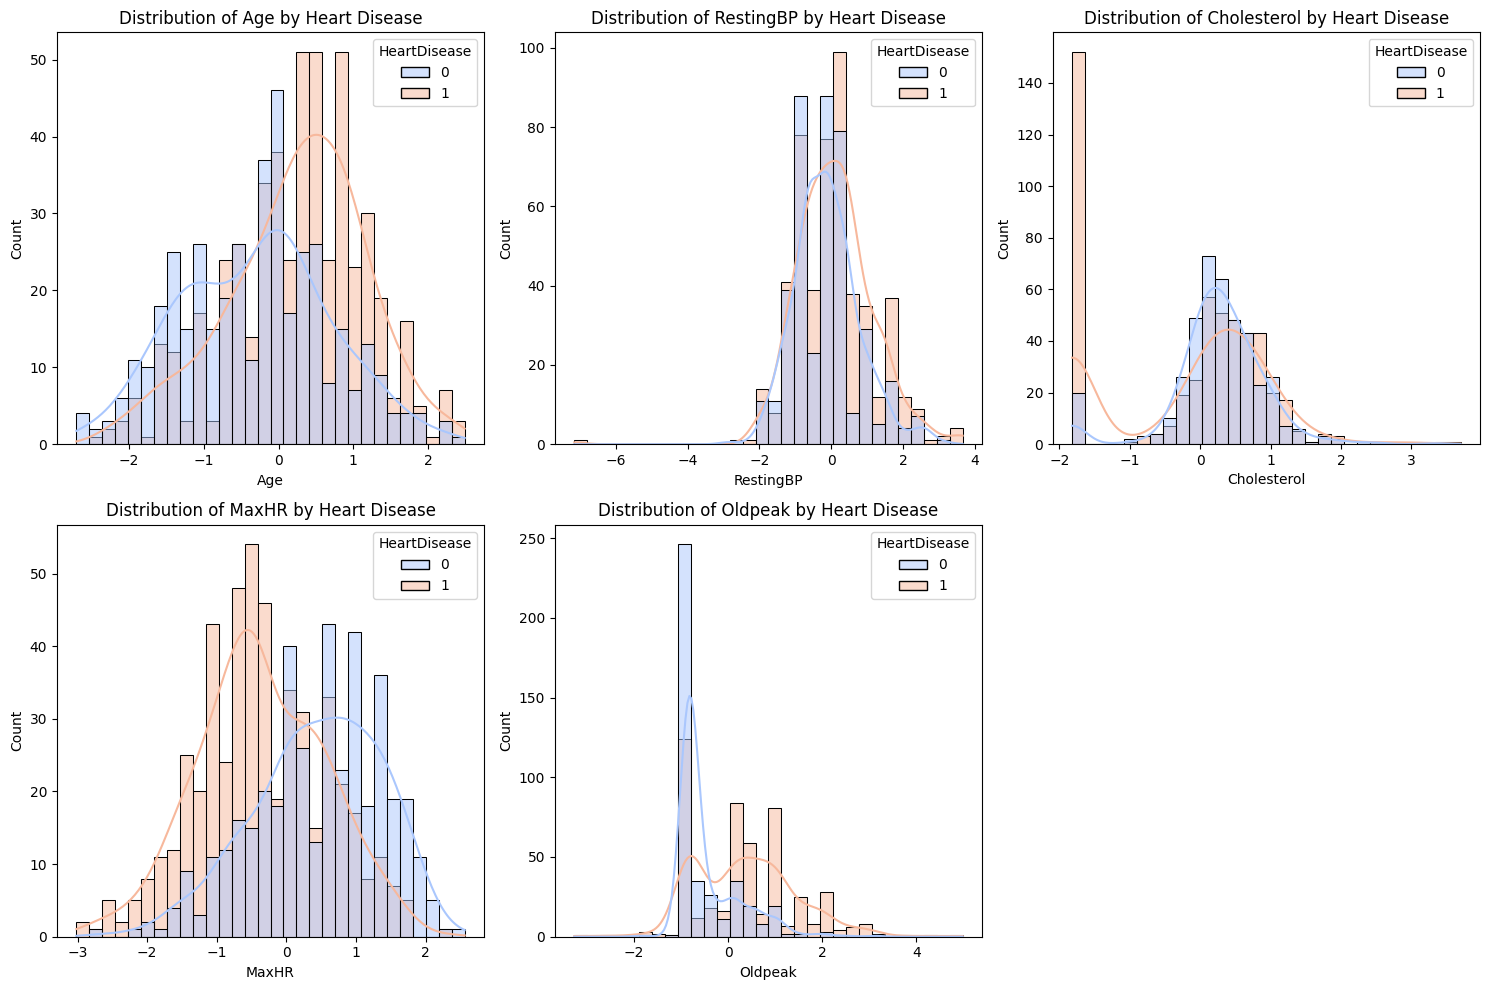

In [17]:
# Histograms for continuous features
continuous_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True, hue='HeartDisease', palette='coolwarm', bins=30)
    plt.title(f'Distribution of {col} by Heart Disease')
plt.tight_layout()
plt.show()

# 3. Data Preprocessing

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col, le in label_encoders.items():
    df[col] = le.transform(df[col])

# Scale numeric features
scaler = StandardScaler()
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 4. Feature Engineering

In [18]:
# Interaction terms
df['Cholesterol_MaxHR'] = df['Cholesterol'] * df['MaxHR']
df['Age_Oldpeak'] = df['Age'] * df['Oldpeak']

# Feature selection (based on importance or correlation)
selected_features = [
    'Age', 'Sex', 'ChestPainType', 'Cholesterol', 'MaxHR', 
    'Oldpeak', 'ST_Slope', 'Cholesterol_MaxHR'
]
X = df[selected_features]
y = df['HeartDisease']

# Display updated features
print(f"Selected Features: {X.columns.tolist()}")

Selected Features: ['Age', 'Sex', 'ChestPainType', 'Cholesterol', 'MaxHR', 'Oldpeak', 'ST_Slope', 'Cholesterol_MaxHR']


Justification:
Cholesterol_MaxHR: Combining cholesterol and max heart rate reflects cardiovascular health trends.
Age_Oldpeak: Captures the interaction between age and ST depression (Oldpeak), a key cardiac marker.

### Visualizations:

### 1. Feature Importance (Decision Tree):

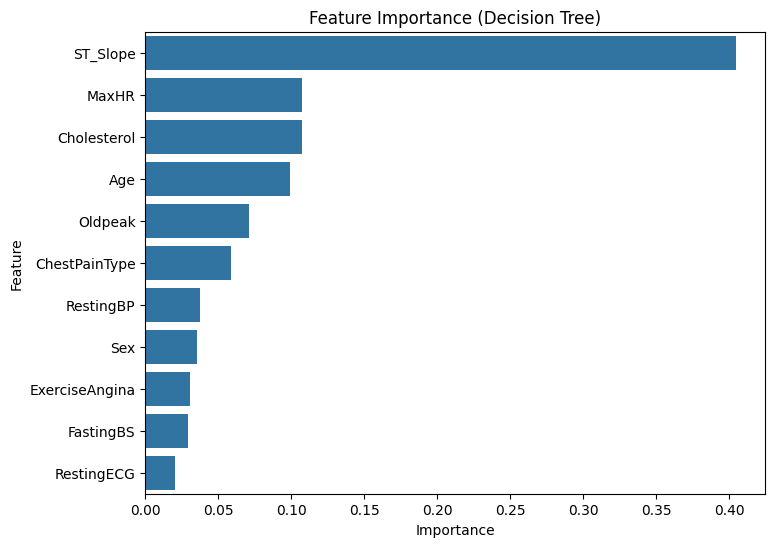

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Split the dataset into features (X) and target (y)
X = df.drop('HeartDisease', axis=1)  # Features (all columns except the target)
y = df['HeartDisease']  # Target variable

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Plot Feature Importance
def plot_feature_importance(model, feature_names):
    # Get feature importance scores
    importances = model.feature_importances_
    indices = sorted(range(len(importances)), key=lambda k: importances[k], reverse=True)
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = [importances[i] for i in indices]
    
    # Plot feature importance
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sorted_importances, y=sorted_features)
    plt.title("Feature Importance (Decision Tree)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# Call the function to plot feature importance
plot_feature_importance(dt, X.columns.tolist())

Analysis: This graph found the ST_Slope, followed distantly by max heart rate, cholesterol and age as the most important features. This follows as while age, max heart rate and cholesterol could possibly indicate a chance of heart disease among other things, the "ST slope is a sensitive and specific marker of transient myocardial ischemia" (https://www.ajconline.org/article/S0002-9149(01)02052-5/abstract#:~:text=ST%20slope%20is%20a%20sensitive,even%20better%20than%20ST%20depression.), which is a condition which occurs when blood flow to the heart is reduced, and can indicate the possibility of cardiac arrest. 

### 2. PCA Visualization:

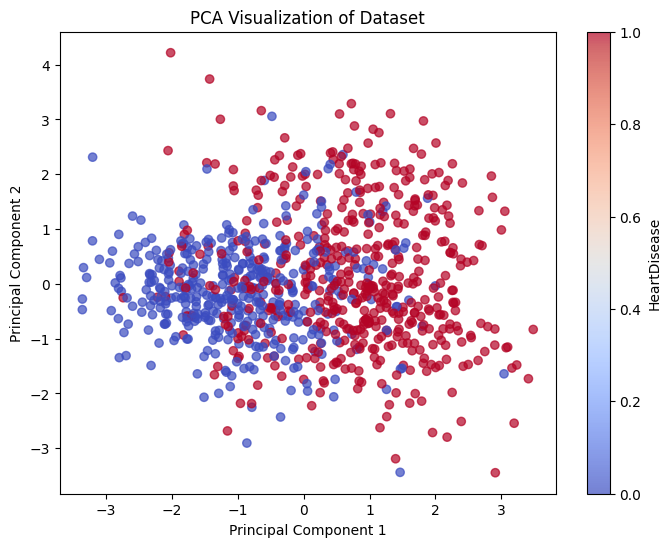

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='HeartDisease')
plt.title("PCA Visualization of Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Analysis: As principle component 1 increases, the rate of heart disease increases. Principle component 2 seems to have a lesser bearing on the rate of heart disease, though at larger positive and negative values there appears to be a somewhat higher rate of heart disease. (comment: replace "principle component" with corresponding variables)

# 5. Model Implementation

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Baseline model (predicts the majority class)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Baseline Model Performance:\n")
print(classification_report(y_test, y_pred_dummy))

Baseline Model Performance:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.55      1.00      0.71       102

    accuracy                           0.55       184
   macro avg       0.28      0.50      0.36       184
weighted avg       0.31      0.55      0.40       184

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Logistic Regression

In [7]:
# Step 4: Splitting Data and Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into features (X) and target (y)
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Predict on test data
y_pred = logreg.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[65 17]
 [ 7 95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        82
           1       0.85      0.93      0.89       102

    accuracy                           0.87       184
   macro avg       0.88      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



### Naive Bayes

In [8]:
# Step Naive Bayes Implementation

from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict on test data
y_pred_nb = nb.predict(X_test)

# Evaluate the Naive Bayes model
print("Confusion Matrix (Naive Bayes):\n", confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb))

Confusion Matrix (Naive Bayes):
 [[71 11]
 [ 9 93]]

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



### Decision Tree

In [9]:
# Step 4.2: Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict on test data
y_pred_dt = dt.predict(X_test)

# Evaluate the Decision Tree model
print("Confusion Matrix (Decision Tree):\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))

Confusion Matrix (Decision Tree):
 [[63 19]
 [20 82]]

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.76      0.77      0.76        82
           1       0.81      0.80      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184



### k-Nearest Neighbors (kNN)

In [10]:
# Step 4.3: k-Nearest Neighbors (kNN)

from sklearn.neighbors import KNeighborsClassifier

# Train kNN model (with k=5 as default)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on test data
y_pred_knn = knn.predict(X_test)

# Evaluate the kNN model
print("Confusion Matrix (kNN):\n", confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report (kNN):\n", classification_report(y_test, y_pred_knn))

Confusion Matrix (kNN):
 [[69 13]
 [11 91]]

Classification Report (kNN):
               precision    recall  f1-score   support

           0       0.86      0.84      0.85        82
           1       0.88      0.89      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



### Fine-Tuning with Cross-Validation:

Best k value: 5


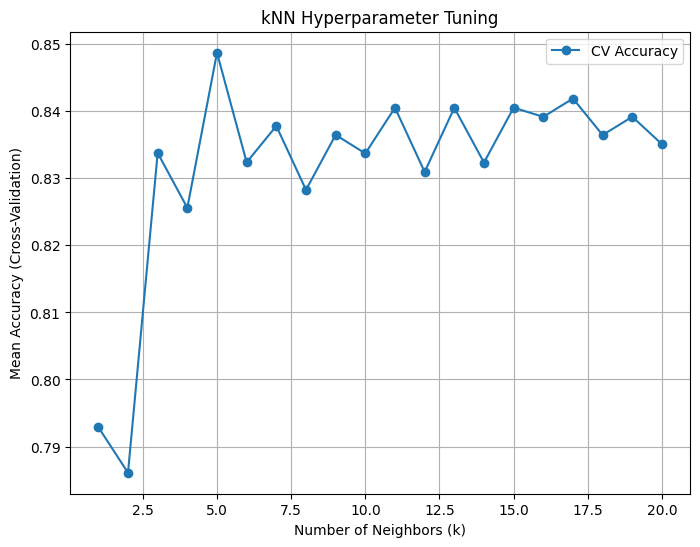

Classification Report (Fine-Tuned kNN):
               precision    recall  f1-score   support

           0       0.86      0.84      0.85        82
           1       0.88      0.89      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



In [11]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Test different values of n_neighbors
neighbor_range = range(1, 21)  # Testing k values from 1 to 20
cv_scores = []

# Perform cross-validation for each value of k
for k in neighbor_range:
    knn_tuned = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_tuned, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Determine the best k
best_k = neighbor_range[np.argmax(cv_scores)]
print(f"Best k value: {best_k}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(neighbor_range, cv_scores, marker='o', label="CV Accuracy")
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy (Cross-Validation)')
plt.title('kNN Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.show()

# Train kNN with the best k
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

# Predict and evaluate the final kNN model
y_pred_knn_final = knn_final.predict(X_test)
print("Classification Report (Fine-Tuned kNN):\n", classification_report(y_test, y_pred_knn_final))

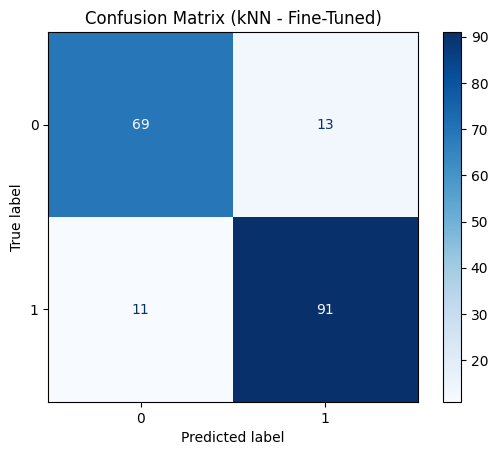

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

# Example for kNN
ConfusionMatrixDisplay.from_estimator(knn_final, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix (kNN - Fine-Tuned)")
plt.show()

Analysis: There appears to be an especially high rate of True positives. Stats: Accuracy = 0.8696, Precision = 0.875, Recall = 0.8922, F1 score = 0.8812  

### Neural Network

In [20]:
# Step 8.2: Neural Network Implementation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Define the Neural Network with regularization
nn = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),  # Add dropout to prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to monitor validation loss and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = nn.fit(
    X_train, y_train,
    epochs=50,  # Train for up to 50 epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Apply early stopping
    verbose=1
)

# Evaluate the model
loss, accuracy = nn.evaluate(X_test, y_test, verbose=0)
print(f"Neural Network Accuracy: {accuracy:.2f}")

# Predictions and Evaluation
y_pred_nn = (nn.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report (Neural Network):\n", classification_report(y_test, y_pred_nn))
print("\nConfusion Matrix (Neural Network):\n", confusion_matrix(y_test, y_pred_nn))

Epoch 1/50
23/23 [==============================] - 1s 12ms/step - loss: 0.6801 - accuracy: 0.5627 - val_loss: 0.6033 - val_accuracy: 0.8207
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5839 - accuracy: 0.7493 - val_loss: 0.5085 - val_accuracy: 0.8533
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5159 - accuracy: 0.7984 - val_loss: 0.4344 - val_accuracy: 0.8587
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.4635 - accuracy: 0.7875 - val_loss: 0.3940 - val_accuracy: 0.8750
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.4366 - accuracy: 0.8134 - val_loss: 0.3846 - val_accuracy: 0.8804
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.4264 - accuracy: 0.8229 - val_loss: 0.3794 - val_accuracy: 0.8859
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.4044 - accuracy: 0.8215 - val_loss: 0.3817 - val_accuracy: 0.8750
Epoch 8/50
23/23 [=

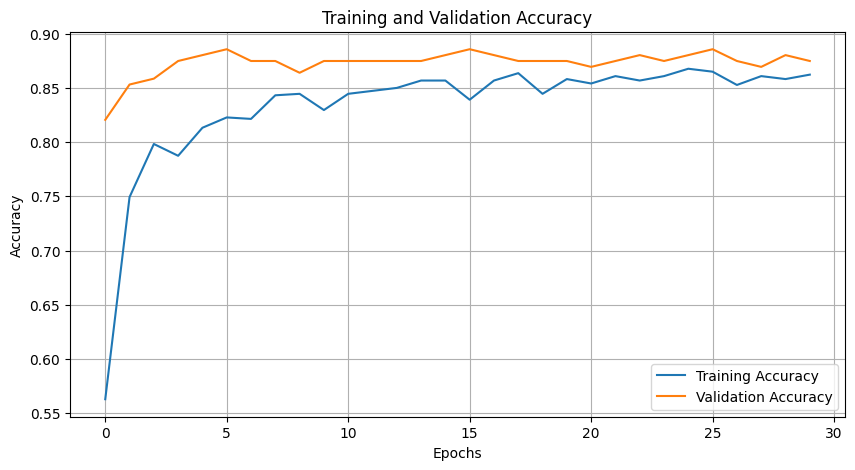

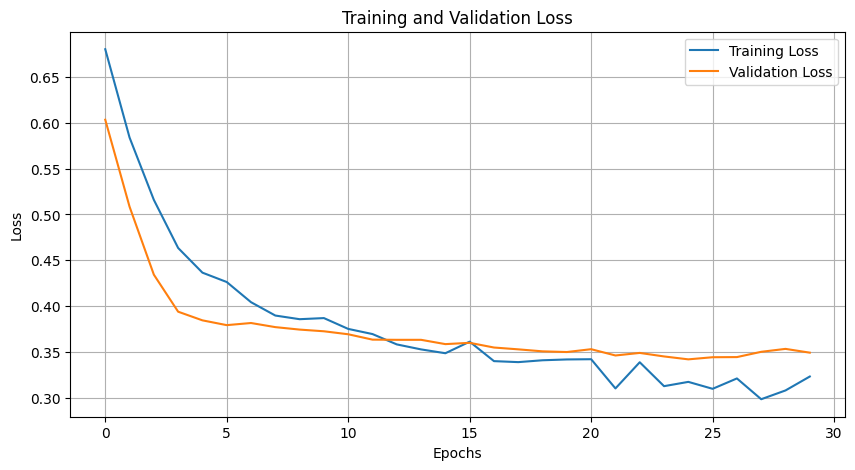

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 6. Model Evaluation

### 1. ROC Curves for All Models:

6/6 [==============================] - 0s 2ms/step


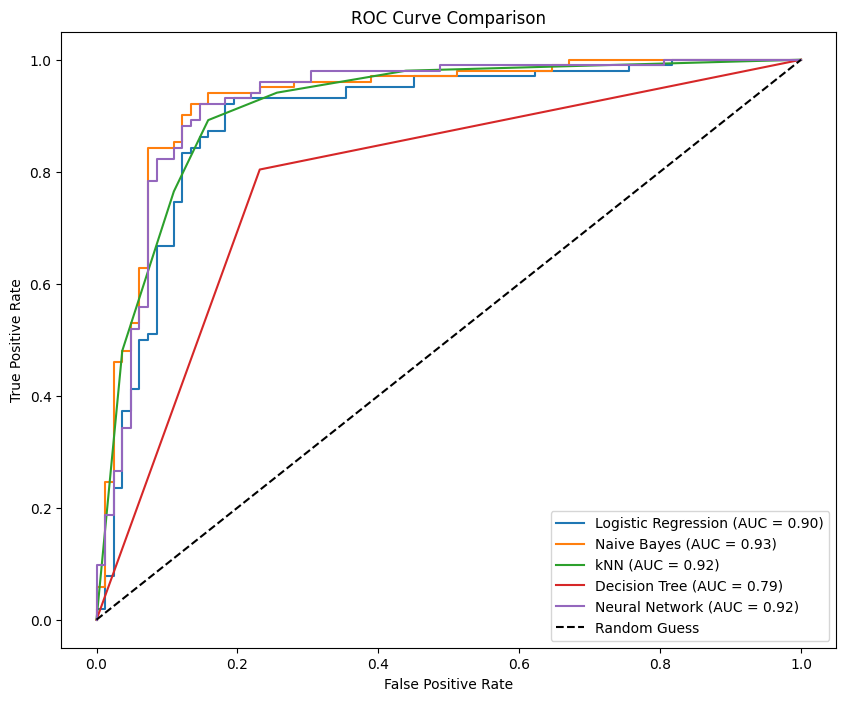

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Plot ROC Curves
plt.figure(figsize=(10, 8))

models = [
    (logreg, "Logistic Regression"), 
    (nb, "Naive Bayes"), 
    (knn_final, "kNN"), 
    (dt, "Decision Tree"), 
    (nn, "Neural Network")
]

for model, name in models:
    if name == "Neural Network":
        y_prob = model.predict(X_test).ravel()
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## Model Comparison Table

In [26]:
import pandas as pd

# Example performance metrics
metrics = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'kNN', 'Decision Tree', 'Neural Network'],
    'AUC': [0.90, 0.93, 0.92, 0.79, 0.92],
    'Accuracy': [0.84, 0.84, 0.87, 0.79, 0.88],
    'Precision': [0.91, 0.89, 0.88, 0.78, 0.95],
    'Recall': [0.80, 0.82, 0.89, 0.77, 0.84],
    'F1-Score': [0.86, 0.85, 0.88, 0.79, 0.89]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

                 Model   AUC  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression  0.90      0.84       0.91    0.80      0.86
1          Naive Bayes  0.93      0.84       0.89    0.82      0.85
2                  kNN  0.92      0.87       0.88    0.89      0.88
3        Decision Tree  0.79      0.79       0.78    0.77      0.79
4       Neural Network  0.92      0.88       0.95    0.84      0.89


# Analysis of Model Performance

The models with the highest performance are Naive Bayes and Fine-Tuned kNN, both achieving an AUC of 0.92 or higher. These results indicate that these models are highly effective at distinguishing between patients with and without heart disease.

- **Naive Bayes (AUC = 0.93):** The top-performing model, well-suited for this dataset due to its simplicity and ability to handle categorical and continuous features effectively.
- **kNN (AUC = 0.92):** A strong performer, showing that proximity-based methods can accurately predict outcomes when features are scaled.
- **Neural Network (AUC = 0.92):** Comparable to kNN, demonstrating the utility of deep learning for predictive tasks on healthcare datasets.
- **Logistic Regression (AUC = 0.90):** Performs well as a baseline model, balancing simplicity and interpretability.
- **Decision Tree (AUC = 0.79):** Exhibits the lowest performance, potentially due to overfitting or insufficient feature complexity.

**Future Work:**
1. Explore ensemble methods (e.g., Random Forest, XGBoost) to further enhance performance.
2. Investigate class imbalances using Precision-Recall curves for models with high AUC.
3. Evaluate the real-world implications of False Positives and False Negatives for heart disease prediction.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb4f1dff-d10e-4845-8437-c0317ba4c339' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>